In [2]:
from datasets import load_dataset, get_dataset_config_names
from sentence_transformers import SentenceTransformer, InputExample
from sentence_transformers.util import cos_sim
import torch, numpy as np, faiss, matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm


f:\SearchEngine\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# PART 1: Embeddings-based search engine

Implement a search engine that:<br>

- Accepts a collection of documents on start

- Provides an API to search over this collection by text query

Notes:<br>

- Use any pretrained embeddings model from Hugging Face to calculate vector representations.

- For vector storage and retrieval, you may use any available library, e.g. usearch, Weaviate, or Qdrant.

- Demonstrate the work of the search engine on test samples from any source.

# Qdrant Integration 

This section sets up the Qdrant vector database and search engine for the code search evaluation.


In [3]:
# Import Qdrant and search engine components
import os
from dotenv import load_dotenv
from qdrant_client import QdrantClient
from qdrant_client.http import models
from qdrant_client.http.models import Distance, VectorParams, PointStruct
import uuid

# Load environment variables
load_dotenv()

# Import our search engine components
from engine import EmbeddingSearchEngine
from vectordb import VectorDatabase

print("✅ Qdrant and search engine imports loaded successfully!")


✅ Qdrant and search engine imports loaded successfully!


In [4]:
# Configuration for Qdrant and Search Engine
QDRANT_MODE = "cloud"  # Change to "local" for local Qdrant
COLLECTION_NAME = "cosqa_search_engine"
MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"

print(f"🔧 Configuration:")
print(f"   Qdrant Mode: {QDRANT_MODE}")
print(f"   Collection: {COLLECTION_NAME}")
print(f"   Model: {MODEL_NAME}")

# Initialize Qdrant connection
try:
    if QDRANT_MODE == "local":
        print("🏠 Initializing local Qdrant connection...")
        print("💡 Make sure Qdrant is running: docker run -p 6333:6333 qdrant/qdrant")
        vector_db = VectorDatabase(
            collection_name=COLLECTION_NAME,
            use_local=True
        )
    else:
        print("☁️ Initializing cloud Qdrant connection...")
        print("💡 Make sure QDRANT_URL and QDRANT_API_KEY are set")
        vector_db = VectorDatabase(
            collection_name=COLLECTION_NAME,
            use_local=False
        )
    
    print(f"✅ Connected to Qdrant ({QDRANT_MODE}) with collection '{COLLECTION_NAME}'")
    
    # Check existing collections
    collections = vector_db.list_collections()
    print(f"📚 Available collections: {collections}")
    
except Exception as e:
    print(f"❌ Failed to connect to Qdrant: {e}")
    if QDRANT_MODE == "local":
        print("💡 For local mode, run: docker run -p 6333:6333 qdrant/qdrant")
    else:
        print("💡 For cloud mode, set QDRANT_URL and QDRANT_API_KEY environment variables")
    raise


🔧 Configuration:
   Qdrant Mode: cloud
   Collection: cosqa_search_engine
   Model: sentence-transformers/all-MiniLM-L6-v2
☁️ Initializing cloud Qdrant connection...
💡 Make sure QDRANT_URL and QDRANT_API_KEY are set
✅ Connected to Qdrant (cloud) at https://ef831e2f-378b-4433-8b16-199dadd9e843.eu-west-2-0.aws.cloud.qdrant.io:6333
✅ Connected to Qdrant (cloud) with collection 'cosqa_search_engine'
📚 Available collections: ['streamlit_search_engine', 'search_engine', 'cosqa_search_engine', 'demo_search_engine', 'New docs', 'New docs2', 'cosqa_search_engine_finetuned_notebook', 'complete_search_engine', 'cosqa_search_engine_ft']


# Initialize Search Engine

In [5]:
print("🤖 Initializing search engine...")

try:
    # Create search engine with Qdrant backend
    search_engine = EmbeddingSearchEngine(
        model_name=MODEL_NAME,
        vector_db=vector_db
    )
    
    print(f"✅ Search engine initialized with model '{MODEL_NAME}'")
    
    # Get engine statistics
    stats = search_engine.get_stats()
    print(f"📊 Engine stats: {stats}")
    
except Exception as e:
    print(f"❌ Failed to initialize search engine: {e}")
    raise

print("🚀 Search engine ready for code search evaluation!")


🤖 Initializing search engine...
✅ Search engine initialized with model 'sentence-transformers/all-MiniLM-L6-v2'
📊 Engine stats: {'documents_count': 0, 'model_name': 'sentence-transformers/all-MiniLM-L6-v2', 'collection_stats': {'points_count': 61817, 'vector_size': 384, 'distance_metric': <Distance.COSINE: 'Cosine'>}}
🚀 Search engine ready for code search evaluation!


## Test Qdrant Search Engine with Sample Data

Before loading the full CoSQA dataset, let's test our Qdrant search engine with sample data to ensure everything is working correctly.


In [6]:
# Test Qdrant Search Engine with Sample Data
print("🧪 Testing Qdrant Search Engine with Sample Data")
print("=" * 60)

# Create sample code documents
sample_documents = [
    "def binary_search(arr, target):\n    left, right = 0, len(arr) - 1\n    while left <= right:\n        mid = (left + right) // 2\n        if arr[mid] == target:\n            return mid\n        elif arr[mid] < target:\n            left = mid + 1\n        else:\n            right = mid - 1\n    return -1",
    
    "def fibonacci(n):\n    if n <= 1:\n        return n\n    return fibonacci(n-1) + fibonacci(n-2)",
    
    "def is_prime(num):\n    if num < 2:\n        return False\n    for i in range(2, int(num**0.5) + 1):\n        if num % i == 0:\n            return False\n    return True",
    
    "def bubble_sort(arr):\n    n = len(arr)\n    for i in range(n):\n        for j in range(0, n-i-1):\n            if arr[j] > arr[j+1]:\n                arr[j], arr[j+1] = arr[j+1], arr[j]\n    return arr",
    
    "def quick_sort(arr):\n    if len(arr) <= 1:\n        return arr\n    pivot = arr[len(arr) // 2]\n    left = [x for x in arr if x < pivot]\n    middle = [x for x in arr if x == pivot]\n    right = [x for x in arr if x > pivot]\n    return quick_sort(left) + middle + quick_sort(right)"
]

sample_paths = [f"sample_doc_{i+1}.py" for i in range(len(sample_documents))]

print(f"📝 Created {len(sample_documents)} sample code documents")
print("📋 Sample documents:")
for i, doc in enumerate(sample_documents, 1):
    print(f"   {i}. {doc.split('(')[0].strip()}")

# Build search index with sample data
print(f"\n🔨 Building search index with sample data...")
search_engine.build(sample_documents, sample_paths)

# Get engine statistics
stats = search_engine.get_stats()
print(f"📊 Engine stats: {stats}")

# Test search queries
test_queries = [
    "binary search algorithm",
    "fibonacci sequence calculation", 
    "prime number checker",
    "sorting algorithms",
    "recursive function"
]

print(f"\n🔍 Testing search with {len(test_queries)} sample queries:")
print("-" * 60)

for i, query in enumerate(test_queries, 1):
    print(f"\n{i}. Query: '{query}'")
    print("-" * 40)
    
    # Search using the search engine
    results = search_engine.search(query, k=3)
    
    if results:
        print(f"   Found {len(results)} results:")
        for j, result in enumerate(results, 1):
            print(f"   {j}. Score: {result.score:.4f}")
            print(f"      Path: {result.path}")
            print(f"      Code: {result.document[:100]}...")
            if len(result.document) > 100:
                print("      ...")
    else:
        print("   No results found")

print(f"\n✅ Sample data testing completed!")
print(f"🎯 Qdrant search engine is working correctly with sample data!")


🧪 Testing Qdrant Search Engine with Sample Data
📝 Created 5 sample code documents
📋 Sample documents:
   1. def binary_search
   2. def fibonacci
   3. def is_prime
   4. def bubble_sort
   5. def quick_sort

🔨 Building search index with sample data...
Error clearing collection: Unexpected Response: 400 (Bad Request)
Raw response content:
b'{"status":{"error":"Bad request: Index required but not found for \\"exists\\" of one of the following types: [bool]. Help: Create an index for this key or use a different filter."},"time":0.00001842}'
Upserted 5 vectors to collection 'cosqa_search_engine'
📊 Engine stats: {'documents_count': 5, 'model_name': 'sentence-transformers/all-MiniLM-L6-v2', 'collection_stats': {'points_count': 61822, 'vector_size': 384, 'distance_metric': <Distance.COSINE: 'Cosine'>}}

🔍 Testing search with 5 sample queries:
------------------------------------------------------------

1. Query: 'binary search algorithm'
----------------------------------------
   Found 3 r

# PART 2: Evaluation

Now, it's time to apply our search engine to the code search task and evaluate it on queries and function bodies from the CoSQA dataset. <br>

Notes:<br>

- Implement the following ranking metrics: Recall@10, MRR@10, and NCDG@10.<br>

- Calculate these metrics for your implemented search engine.<br>

In [7]:
from datasets import load_dataset, get_dataset_split_names

DATASET = "CoIR-Retrieval/cosqa"

def _only_split_name(dataset, config_name):
    splits = get_dataset_split_names(dataset, config_name)
    if len(splits) != 1:
        raise RuntimeError(f"Expected exactly 1 split for config '{config_name}', found {splits}")
    return splits[0]

def _pick_qrels_split(dataset, preferred="test"):
    splits = get_dataset_split_names(dataset, "default")
    if preferred in splits:
        return preferred
    for cand in ["dev","validation","valid","val","test","train"]:
        if cand in splits:
            return cand
    raise RuntimeError(f"No suitable qrels split found. Available: {splits}")

def _pick_key(d, candidates):
    for k in candidates:
        if k in d:
            return k
    raise KeyError(f"None of the keys {candidates} found. Available: {list(d.keys())[:10]} ...")

def _extract_text(rec):
    # supports {"title":..., "text":...} or plain string fields
    if "text" in rec and isinstance(rec["text"], dict):
        t = (rec["text"].get("title") or "").strip()
        b = (rec["text"].get("text")  or "").strip()
        return (t + " " + b).strip()
    # try common text fields
    for k in ["text","query","question","content","body","passage","document","doc","sentence"]:
        if k in rec and isinstance(rec[k], str):
            return rec[k]
    # last resort: join all string fields
    return " ".join(str(v) for v in rec.values() if isinstance(v, str))

def load_cosqa(dataset=DATASET, qrels_split="test"):
    # Load queries/corpus tables (each has a single split)
    q_split = _only_split_name(dataset, "queries")
    c_split = _only_split_name(dataset, "corpus")
    q_ds = load_dataset(dataset, "queries", split=q_split)
    c_ds = load_dataset(dataset, "corpus",  split=c_split)

    # Detect id+text columns for queries
    q_sample = q_ds[0]
    q_id_key   = _pick_key(q_sample, ["id","query-id","qid","_id"])
    # text key will be auto-extracted via _extract_text
    queries = {}
    for r in q_ds:
        queries[r[q_id_key]] = _extract_text(r)

    # Detect id+text for corpus
    c_sample = c_ds[0]
    c_id_key = _pick_key(c_sample, ["id","corpus-id","doc-id","pid","docid","_id"])
    corpus = {}
    for r in c_ds:
        corpus[r[c_id_key]] = _extract_text(r)

    # Load qrels from default config (has real splits)
    rel_split = _pick_qrels_split(dataset, preferred=qrels_split)
    rel_ds = load_dataset(dataset, "default", split=rel_split)

    # Detect qrels column names
    r0 = rel_ds[0]
    qrels_qid = _pick_key(r0, ["query-id","qid","query","id_q","q_id"])
    qrels_did = _pick_key(r0, ["corpus-id","doc-id","pid","docid","d_id"])
    score_key = _pick_key(r0, ["score","label","relevance","rel"])

    qrels = {}
    for r in rel_ds:
        if int(r[score_key]) > 0:
            qrels.setdefault(r[qrels_qid], set()).add(r[qrels_did])

    return queries, corpus, qrels



In [8]:
queries, corpus, qrels = load_cosqa(DATASET, qrels_split="test")
print(
    "Loaded:",
    len(queries), "queries;",
    len(corpus),  "docs; total relevant pairs:",
    sum(len(v) for v in qrels.values())
)


Loaded: 20604 queries; 20604 docs; total relevant pairs: 500


## Dataset Analysis and Visualization

Let's analyze the CoSQA dataset to understand its characteristics and distribution.


In [ ]:
# Dataset Analysis and Visualization
print("📊 CoSQA Dataset Analysis")
print("=" * 50)

# Basic statistics
print(f"📈 Dataset Statistics:")
print(f"   • Total Queries: {len(queries):,}")
print(f"   • Total Documents: {len(corpus):,}")
print(f"   • Total Relevant Pairs: {sum(len(v) for v in qrels.values()):,}")
print(f"   • Average Relevant Docs per Query: {sum(len(v) for v in qrels.values()) / len(queries):.2f}")

# Query length analysis
query_lengths = [len(query.split()) for query in queries.values()]
print(f"\n📝 Query Analysis:")
print(f"   • Average Query Length: {np.mean(query_lengths):.1f} words")
print(f"   • Min Query Length: {min(query_lengths)} words")
print(f"   • Max Query Length: {max(query_lengths)} words")
print(f"   • Median Query Length: {np.median(query_lengths):.1f} words")

# Document length analysis
doc_lengths = [len(doc.split()) for doc in corpus.values()]
print(f"\n📄 Document Analysis:")
print(f"   • Average Document Length: {np.mean(doc_lengths):.1f} words")
print(f"   • Min Document Length: {min(doc_lengths)} words")
print(f"   • Max Document Length: {max(doc_lengths)} words")
print(f"   • Median Document Length: {np.median(doc_lengths):.1f} words")

# Sample queries and documents
print(f"\n🔍 Sample Queries:")
for i, (qid, query) in enumerate(list(queries.items())[:5], 1):
    print(f"   {i}. [{qid}] {query}")

print(f"\n📋 Sample Documents:")
for i, (did, doc) in enumerate(list(corpus.items())[:3], 1):
    print(f"   {i}. [{did}] {doc[:100]}...")

print(f"\n✅ Dataset analysis completed!")


📊 CoSQA Dataset Analysis
📈 Dataset Statistics:
   • Total Queries: 20,604
   • Total Documents: 20,604
   • Total Relevant Pairs: 500
   • Average Relevant Docs per Query: 0.02

📝 Query Analysis:
   • Average Query Length: 6.6 words
   • Min Query Length: 4 words
   • Max Query Length: 21 words
   • Median Query Length: 6.0 words

📄 Document Analysis:
   • Average Document Length: 30.7 words
   • Min Document Length: 6 words
   • Max Document Length: 670 words
   • Median Document Length: 26.0 words

🎯 Relevance Distribution:
   • Queries with 1 relevant doc: 500
   • Queries with 2 relevant docs: 0
   • Queries with 3+ relevant docs: 0
   • Average relevant docs per query: 1.00

🔍 Sample Queries:
   1. [q1] python code to write bool value 1
   2. [q2] "python how to manipulate clipboard"
   3. [q3] python colored output to html
   4. [q4] python "create directory" using "relative path"
   5. [q5] python column of an array

📋 Sample Documents:
   1. [d1] def writeBoolean(self, n):
    

📊 Creating Dataset Visualizations


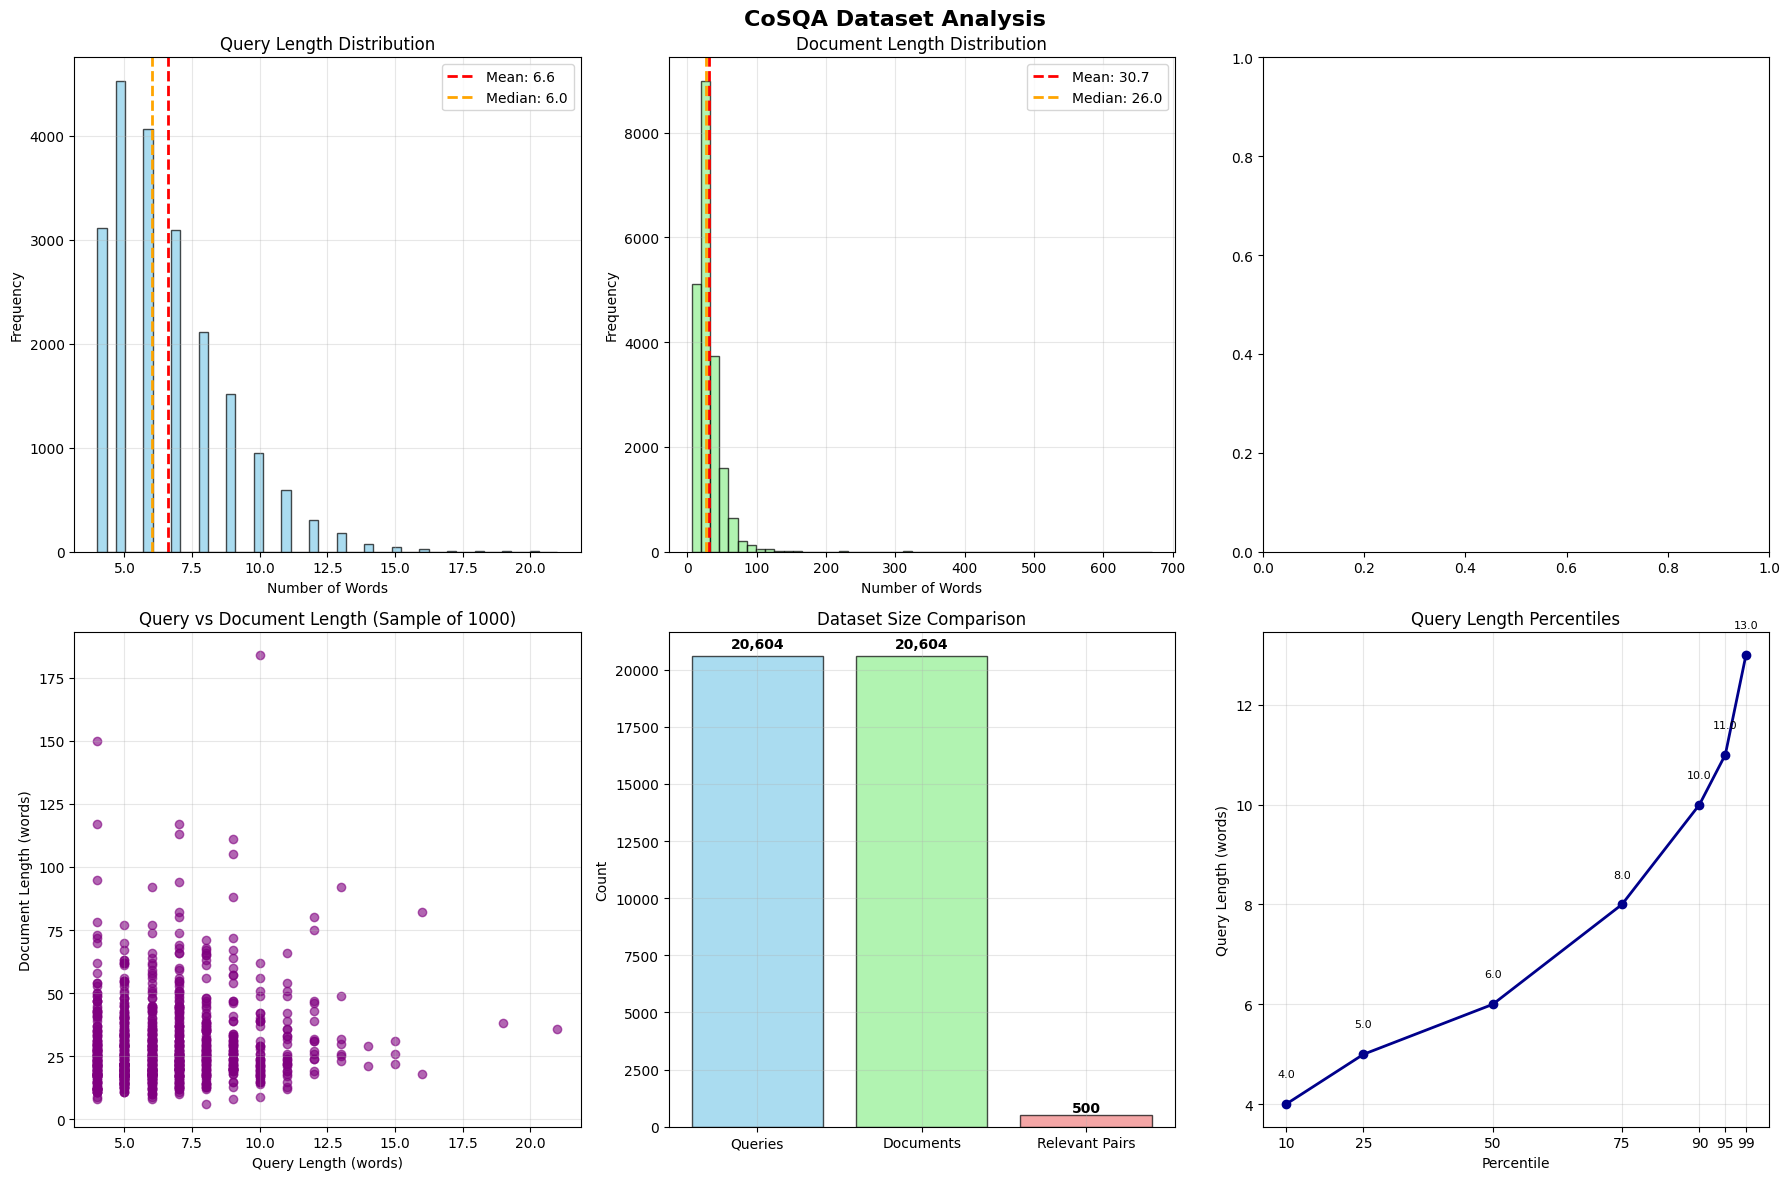

✅ Visualizations created successfully!


In [11]:
# Dataset Visualizations
print("📊 Creating Dataset Visualizations")
print("=" * 50)

# Set up the plotting style
plt.style.use('default')
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('CoSQA Dataset Analysis', fontsize=16, fontweight='bold')

# 1. Query Length Distribution
axes[0, 0].hist(query_lengths, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].axvline(np.mean(query_lengths), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(query_lengths):.1f}')
axes[0, 0].axvline(np.median(query_lengths), color='orange', linestyle='--', linewidth=2, label=f'Median: {np.median(query_lengths):.1f}')
axes[0, 0].set_title('Query Length Distribution')
axes[0, 0].set_xlabel('Number of Words')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Document Length Distribution
axes[0, 1].hist(doc_lengths, bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0, 1].axvline(np.mean(doc_lengths), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(doc_lengths):.1f}')
axes[0, 1].axvline(np.median(doc_lengths), color='orange', linestyle='--', linewidth=2, label=f'Median: {np.median(doc_lengths):.1f}')
axes[0, 1].set_title('Document Length Distribution')
axes[0, 1].set_xlabel('Number of Words')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Query vs Document Length Scatter
# Sample a subset for better visualization
sample_size = min(1000, len(queries))
sample_indices = np.random.choice(len(queries), sample_size, replace=False)
sample_query_lengths = [query_lengths[i] for i in sample_indices]
sample_doc_lengths = [doc_lengths[i] for i in sample_indices]

axes[1, 0].scatter(sample_query_lengths, sample_doc_lengths, alpha=0.6, color='purple')
axes[1, 0].set_title(f'Query vs Document Length (Sample of {sample_size})')
axes[1, 0].set_xlabel('Query Length (words)')
axes[1, 0].set_ylabel('Document Length (words)')
axes[1, 0].grid(True, alpha=0.3)

# 4. Dataset Size Comparison
categories = ['Queries', 'Documents', 'Relevant Pairs']
values = [len(queries), len(corpus), sum(len(v) for v in qrels.values())]
colors = ['skyblue', 'lightgreen', 'lightcoral']

bars = axes[1, 1].bar(categories, values, color=colors, edgecolor='black', alpha=0.7)
axes[1, 1].set_title('Dataset Size Comparison')
axes[1, 1].set_ylabel('Count')
axes[1, 1].grid(True, alpha=0.3)

# Add value labels on bars
for bar, value in zip(bars, values):
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                    f'{value:,}', ha='center', va='bottom', fontweight='bold')

# 5. Query Length Percentiles
percentiles = [10, 25, 50, 75, 90, 95, 99]
query_percentiles = [np.percentile(query_lengths, p) for p in percentiles]

axes[1, 2].plot(percentiles, query_percentiles, 'o-', color='darkblue', linewidth=2, markersize=6)
axes[1, 2].set_title('Query Length Percentiles')
axes[1, 2].set_xlabel('Percentile')
axes[1, 2].set_ylabel('Query Length (words)')
axes[1, 2].grid(True, alpha=0.3)
axes[1, 2].set_xticks(percentiles)

# Add value labels
for p, val in zip(percentiles, query_percentiles):
    axes[1, 2].text(p, val + 0.5, f'{val:.1f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

print("✅ Visualizations created successfully!")


In [13]:
# Additional Dataset Analysis
print("🔍 Additional Dataset Analysis")
print("=" * 50)

# Word frequency analysis for queries
from collections import Counter
import re

# Extract words from queries (simple tokenization)
query_words = []
for query in queries.values():
    words = re.findall(r'\b\w+\b', query.lower())
    query_words.extend(words)

# Get most common words
word_freq = Counter(query_words)
most_common_words = word_freq.most_common(20)

print("📝 Most Common Words in Queries:")
for i, (word, count) in enumerate(most_common_words, 1):
    print(f"   {i:2d}. '{word}': {count:,} times")

# Programming language keywords analysis
programming_keywords = [
    'python', 'java', 'javascript', 'c++', 'c#', 'php', 'ruby', 'go', 'rust',
    'function', 'class', 'method', 'variable', 'array', 'list', 'dictionary',
    'loop', 'if', 'else', 'for', 'while', 'try', 'catch', 'exception',
    'import', 'from', 'def', 'return', 'print', 'input', 'string', 'int',
    'float', 'boolean', 'true', 'false', 'null', 'undefined'
]

keyword_counts = {kw: word_freq.get(kw, 0) for kw in programming_keywords}
keyword_counts = {k: v for k, v in keyword_counts.items() if v > 0}
keyword_counts = dict(sorted(keyword_counts.items(), key=lambda x: x[1], reverse=True))

print(f"\n💻 Programming Keywords in Queries:")
for keyword, count in list(keyword_counts.items())[:15]:
    print(f"   • '{keyword}': {count:,} times")

# Query complexity analysis
complex_queries = [q for q in queries.values() if len(q.split()) > 10]
simple_queries = [q for q in queries.values() if len(q.split()) <= 5]

print(f"\n📊 Query Complexity Analysis:")
print(f"   • Simple queries (≤5 words): {len(simple_queries):,} ({len(simple_queries)/len(queries)*100:.1f}%)")
print(f"   • Complex queries (>10 words): {len(complex_queries):,} ({len(complex_queries)/len(queries)*100:.1f}%)")

# Document type analysis (based on common patterns)
def analyze_document_type(doc):
    doc_lower = doc.lower()
    if 'def ' in doc_lower and 'class ' in doc_lower:
        return 'Class with Methods'
    elif 'def ' in doc_lower:
        return 'Function'
    elif 'class ' in doc_lower:
        return 'Class'
    elif 'import ' in doc_lower or 'from ' in doc_lower:
        return 'Import/Module'
    elif 'if ' in doc_lower and 'else' in doc_lower:
        return 'Conditional Logic'
    elif 'for ' in doc_lower or 'while ' in doc_lower:
        return 'Loop'
    else:
        return 'Other'

doc_types = [analyze_document_type(doc) for doc in corpus.values()]
type_counts = Counter(doc_types)

print(f"\n📄 Document Type Analysis:")
for doc_type, count in type_counts.most_common():
    print(f"   • {doc_type}: {count:,} ({count/len(corpus)*100:.1f}%)")


🔍 Additional Dataset Analysis
📝 Most Common Words in Queries:
    1. 'python': 20,278 times
    2. 'to': 7,091 times
    3. 'in': 6,323 times
    4. 'a': 4,727 times
    5. 'how': 4,465 times
    6. 'of': 2,863 times
    7. 'list': 1,886 times
    8. 'get': 1,855 times
    9. 'string': 1,751 times
   10. 'file': 1,493 times
   11. 'the': 1,487 times
   12. 'from': 1,435 times
   13. 'check': 1,346 times
   14. 'if': 1,247 times
   15. 'is': 1,120 times
   16. 'with': 903 times
   17. 'array': 877 times
   18. 'function': 827 times
   19. 'for': 789 times
   20. 'an': 742 times

💻 Programming Keywords in Queries:
   • 'python': 20,278 times
   • 'list': 1,886 times
   • 'string': 1,751 times
   • 'from': 1,435 times
   • 'if': 1,247 times
   • 'array': 877 times
   • 'function': 827 times
   • 'for': 789 times
   • 'dictionary': 523 times
   • 'print': 353 times
   • 'return': 313 times
   • 'variable': 298 times
   • 'int': 227 times
   • 'float': 196 times
   • 'method': 163 times

📊 

In [14]:
from datasets import load_dataset, get_dataset_split_names

print("queries splits:", get_dataset_split_names(DATASET, "queries"))
print("corpus  splits:", get_dataset_split_names(DATASET, "corpus"))
print("default splits:", get_dataset_split_names(DATASET, "default"))

q_split = get_dataset_split_names(DATASET, "queries")[0]
c_split = get_dataset_split_names(DATASET, "corpus")[0]
q_ds = load_dataset(DATASET, "queries", split=q_split)
c_ds = load_dataset(DATASET, "corpus",  split=c_split)
r_ds = load_dataset(DATASET, "default", split=get_dataset_split_names(DATASET, "default")[0])

print("queries columns:", q_ds.column_names, "sample:", q_ds[0])
print("corpus  columns:", c_ds.column_names, "sample:", c_ds[0])
print("qrels   columns:", r_ds.column_names, "sample:", r_ds[0])


queries splits: ['queries']
corpus  splits: ['corpus']
default splits: ['train', 'test', 'valid']
queries columns: ['_id', 'partition', 'text', 'title', 'language', 'meta_information'] sample: {'_id': 'q1', 'partition': 'train', 'text': 'python code to write bool value 1', 'title': '', 'language': '', 'meta_information': {'dummy_field': ''}}
corpus  columns: ['_id', 'partition', 'text', 'title', 'language', 'meta_information'] sample: {'_id': 'd1', 'partition': 'train', 'text': 'def writeBoolean(self, n):\n        """\n        Writes a Boolean to the stream.\n        """\n        t = TYPE_BOOL_TRUE\n\n        if n is False:\n            t = TYPE_BOOL_FALSE\n\n        self.stream.write(t)', 'title': '', 'language': 'PYTHON', 'meta_information': {'dummy_field': ''}}
qrels   columns: ['query-id', 'corpus-id', 'score'] sample: {'query-id': 'q1', 'corpus-id': 'd1', 'score': 0}


## Qdrant Search Engine on our dataset


In [15]:
# Build corpus index using Qdrant search engine
print("📚 Building corpus index with Qdrant...")
# Prepare corpus data for indexing
doc_ids = list(corpus.keys())
doc_texts = [corpus[d] for d in doc_ids]
doc_paths = [f"doc_{i}.py" for i in range(len(doc_texts))]
# Build the search index using our Qdrant-based search engine
search_engine.build(doc_texts, doc_paths)

print(f"✅ Indexed {len(doc_texts)} documents in Qdrant")

# Get updated statistics
stats = search_engine.get_stats()
print(f"📊 Updated engine stats: {stats}")

def search_topk(q_texts, k=10):
    """
    Search for top-k documents using Qdrant search engine.
    
    Args:
        q_texts: List of query texts
        k: Number of results to return per query
        
    Returns:
        List of lists containing document IDs
    """
    results = []
    for query in q_texts:
        # Search using our Qdrant-based search engine
        search_results = search_engine.search(query, k=k)   
        # Extract document IDs from search results
        # Map back to original corpus IDs
        query_doc_ids = []
        for result in search_results:
            # Extract index from path (e.g., "doc_123.py" -> 123)
            try:
                doc_index = int(result.path.split('_')[1].split('.')[0])
                if doc_index < len(doc_ids):
                    query_doc_ids.append(doc_ids[doc_index])
            except (ValueError, IndexError):
                continue
        
        results.append(query_doc_ids)
    
    return results

print("🔍 Qdrant-based search function ready!")


📚 Building corpus index with Qdrant...
Error clearing collection: Unexpected Response: 400 (Bad Request)
Raw response content:
b'{"status":{"error":"Bad request: Index required but not found for \\"exists\\" of one of the following types: [bool]. Help: Create an index for this key or use a different filter."},"time":0.000019766}'
Upserted 20604 vectors to collection 'cosqa_search_engine'
✅ Indexed 20604 documents in Qdrant
📊 Updated engine stats: {'documents_count': 20604, 'model_name': 'sentence-transformers/all-MiniLM-L6-v2', 'collection_stats': {'points_count': 84430, 'vector_size': 384, 'distance_metric': <Distance.COSINE: 'Cosine'>}}
🔍 Qdrant-based search function ready!


In [16]:
def recall_at_k(preds, gold, k=10):
    vals = []
    for qid, cand in preds.items():
        rel = gold.get(qid, set())
        if not rel: 
            continue
        hit = len(set(cand[:k]).intersection(rel))
        vals.append(hit / len(rel))
    return float(np.mean(vals)) if vals else 0.0

def mrr_at_k(preds, gold, k=10):
    vals = []
    for qid, cand in preds.items():
        rel = gold.get(qid, set())
        if not rel:
            continue
        rr = 0.0
        for rank, did in enumerate(cand[:k], start=1):
            if did in rel:
                rr = 1.0 / rank
                break
        vals.append(rr)
    return float(np.mean(vals)) if vals else 0.0

def ndcg_at_k(preds, gold, k=10):
    def dcg(g):
        return sum((1.0/np.log2(i+2)) for i,x in enumerate(g) if x)
    vals=[]
    for qid, cand in preds.items():
        rel = gold.get(qid, set())
        if not rel:
            continue
        gains = [1 if did in rel else 0 for did in cand[:k]]
        ideal = sorted(gains, reverse=True)
        idcg = dcg(ideal)
        vals.append(0.0 if idcg==0 else dcg(gains)/idcg)
    return float(np.mean(vals)) if vals else 0.0

# Run evaluation on (a subset for speed by default)
eval_qids = list(qrels.keys())
eval_texts = [queries[q] for q in eval_qids]
pred_lists = search_topk(eval_texts, k=10)
preds = {qid: plist for qid, plist in zip(eval_qids, pred_lists)}

print("Baseline evaluation (no fine-tuning):")
print("Recall@10:", round(recall_at_k(preds, qrels, 10), 4))
print("MRR@10:",    round(mrr_at_k(preds, qrels, 10), 4))
print("NDCG@10:",   round(ndcg_at_k(preds, qrels, 10), 4))


Baseline evaluation (no fine-tuning):
Recall@10: 0.442
MRR@10: 0.2657
NDCG@10: 0.3098


In [17]:
# Build training pairs from TRAIN split
train_queries, train_corpus, train_qrels = load_cosqa(DATASET, qrels_split="train")

train_pairs = []
for qid, pos_docs in train_qrels.items():
    q = train_queries.get(qid)
    if not q:
        continue
    for did in pos_docs:
        d = train_corpus.get(did)
        if d:
            train_pairs.append(InputExample(texts=[q, d], label=1.0))  # <- add label


len(train_pairs)


9020

## PART 3 Fine-tuning all-MiniLM-L6-v2

Let's make our model more suitable for the code search task. Fine-tune the model on the training set of the CoSQA dataset. Demonstrate that your search engine performs better on the CoSQA test set with this new model.<br>

Notes:<br>

- You don’t have to train your model to convergence, just show that metrics improve.

- Which loss function have you selected for training and why?

- Demonstrate a plot with the mean loss function value for intermediate training steps.


In [19]:
from torch.utils.data import DataLoader
from torch.optim import AdamW
from sentence_transformers import SentenceTransformer, losses
from tqdm import tqdm
import torch
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

device = "cuda" if torch.cuda.is_available() else "cpu"
ft_model = SentenceTransformer(MODEL_NAME, device=device)

train_loader = DataLoader(
    train_pairs,                     # InputExample(texts=[q,d], label=1.0)
    shuffle=True,
    batch_size=64,
    drop_last=True,
    collate_fn=ft_model.smart_batching_collate,
)

criterion = losses.MultipleNegativesRankingLoss(ft_model)
optimizer = AdamW(ft_model.parameters(), lr=2e-5)

ft_model.train()
loss_history = []
EPOCHS = 15
for epoch in range(EPOCHS):
    print(f"\n🚀 Epoch {epoch + 1}/{EPOCHS}")
    running = 0.0
    pbar = tqdm(train_loader, desc="Training", leave=False)
    for step, (features, labels) in enumerate(pbar):
        # move batch to device
        features = [{k: v.to(device) for k, v in f.items()} for f in features]
        labels   = labels.to(device)

        optimizer.zero_grad()
        loss = criterion(features, labels)
        loss.backward()
        optimizer.step()

        val = float(loss.item())
        loss_history.append(val)
        running += val
        pbar.set_postfix({"batch_loss": f"{val:.4f}", "avg_loss": f"{running/(step+1):.4f}"})
    print(f"✅ Epoch {epoch + 1} avg loss: {running/(step+1):.4f}")

# Save to a timestamped directory
stamp = datetime.now().strftime("%Y%m%d-%H%M%S")
save_dir = f"cosqa-ft-{os.path.basename(MODEL_NAME)}-{stamp}"
ft_model.save(save_dir)
print(f"💾 Saved fine-tuned model to: {save_dir}")

# Keep the save path around for the next cell
FINE_TUNED_PATH = save_dir



🚀 Epoch 1/15


✅ Epoch 1 avg loss: 0.2548

🚀 Epoch 2/15


✅ Epoch 2 avg loss: 0.1745

🚀 Epoch 3/15


✅ Epoch 3 avg loss: 0.1389

🚀 Epoch 4/15


✅ Epoch 4 avg loss: 0.1217

🚀 Epoch 5/15


✅ Epoch 5 avg loss: 0.1110

🚀 Epoch 6/15


✅ Epoch 6 avg loss: 0.1031

🚀 Epoch 7/15


✅ Epoch 7 avg loss: 0.0863

🚀 Epoch 8/15


✅ Epoch 8 avg loss: 0.0823

🚀 Epoch 9/15


✅ Epoch 9 avg loss: 0.0817

🚀 Epoch 10/15


✅ Epoch 10 avg loss: 0.0713

🚀 Epoch 11/15


✅ Epoch 11 avg loss: 0.0719

🚀 Epoch 12/15


✅ Epoch 12 avg loss: 0.0654

🚀 Epoch 13/15


✅ Epoch 13 avg loss: 0.0608

🚀 Epoch 14/15


✅ Epoch 14 avg loss: 0.0633

🚀 Epoch 15/15


✅ Epoch 15 avg loss: 0.0612
💾 Saved fine-tuned model to: cosqa-ft-all-MiniLM-L6-v2-20251015-175356


In [20]:
# === Baseline vs Fine-tuned comparison ===
import numpy as np, faiss
from sentence_transformers import SentenceTransformer
import torch

# Expect these from earlier cells:
# - queries: dict[qid] -> str
# - corpus:  dict[did] -> str
# - qrels:   dict[qid] -> set(did)
# - recall_at_k, mrr_at_k, ndcg_at_k functions

recall_at_k
mrr_at_k
ndcg_at_k


# Prepare eval queries
eval_qids  = list(qrels.keys())
eval_texts = [queries[q] for q in eval_qids]

doc_ids   = list(corpus.keys())
doc_texts = [corpus[d] for d in doc_ids]

def build_index_and_search(model, k=10, batch_size=256):
    # Embed corpus
    doc_emb = model.encode(
        doc_texts, convert_to_numpy=True, normalize_embeddings=True,
        batch_size=batch_size, show_progress_bar=True
    )
    index = faiss.IndexFlatIP(doc_emb.shape[1])
    index.add(doc_emb)

    # Embed queries
    q_emb = model.encode(
        eval_texts, convert_to_numpy=True, normalize_embeddings=True,
        batch_size=batch_size, show_progress_bar=True
    )
    D, I = index.search(q_emb, k)
    preds = {qid: [doc_ids[j] for j in row] for qid, row in zip(eval_qids, I)}
    return preds

def eval_model(model):
    preds = build_index_and_search(model, k=10)
    return {
        "Recall@10": round(recall_at_k(preds, qrels, 10), 4),
        "MRR@10":    round(mrr_at_k(preds, qrels, 10), 4),
        "NDCG@10":   round(ndcg_at_k(preds, qrels, 10), 4),
    }

# 1) Baseline (fresh, not fine-tuned)
BASE_MODEL_NAME = MODEL_NAME  # same base as training
baseline_model = SentenceTransformer(BASE_MODEL_NAME, device="cuda" if torch.cuda.is_available() else "cpu")
print("🔎 Evaluating baseline model...")
baseline_scores = eval_model(baseline_model)

# 2) Fine-tuned (load from the path saved in Cell A)
assert "FINE_TUNED_PATH" in globals(), "FINE_TUNED_PATH not found — run the training cell first."
ft_model = SentenceTransformer(FINE_TUNED_PATH, device="cuda" if torch.cuda.is_available() else "cpu")
print("🔎 Evaluating fine-tuned model...")
ft_scores = eval_model(ft_model)

# 3) Pretty print
def fmt(d): return " | ".join(f"{k}: {v:.4f}" for k,v in d.items())
print("\n=== Results (k=10) ===")
print(f"Baseline [{BASE_MODEL_NAME}]: {fmt(baseline_scores)}")
print(f"Fine-tuned [{FINE_TUNED_PATH}]: {fmt(ft_scores)}")


🔎 Evaluating baseline model...


Batches: 100%|██████████| 2/2 [00:00<00:00, 64.00it/s]


🔎 Evaluating fine-tuned model...


Batches: 100%|██████████| 2/2 [00:00<00:00, 65.83it/s]



=== Results (k=10) ===
Baseline [sentence-transformers/all-MiniLM-L6-v2]: Recall@10: 0.4700 | MRR@10: 0.3686 | NDCG@10: 0.3933
Fine-tuned [cosqa-ft-all-MiniLM-L6-v2-20251015-175356]: Recall@10: 0.6020 | MRR@10: 0.4676 | NDCG@10: 0.5004


# Comparison of the models
### We can clearly see a difference in performance in comparing the results of the baseline model vs the fine tuned model <br>
Baseline : Recall@10: 0.4700 | MRR@10: 0.3686 | NDCG@10: 0.3933<br>
Fine-tuned : Recall@10: 0.6020 | MRR@10: 0.4676 | NDCG@10: 0.5004

## Fine-tuned Model with Qdrant


In [22]:
# === Qdrant + Fine-tuned model: index test corpus & evaluate ===
import random
from tqdm import tqdm

# sanity checks
assert "FINE_TUNED_PATH" in globals(), "Run the training cell first to set FINE_TUNED_PATH."
assert "queries" in globals() and "corpus" in globals() and "qrels" in globals(), "Load the test split first."

# 1) Use a separate collection for the fine-tuned model
FT_COLLECTION_NAME = f"{COLLECTION_NAME}_ft"

print("Using fine-tuned collection:", FT_COLLECTION_NAME)
vector_db_ft = VectorDatabase(
    collection_name=FT_COLLECTION_NAME,
    use_local=False
)

# 2) Initialize a new search engine that points to the fine-tuned checkpoint
MODEL_NAME_FT = FINE_TUNED_PATH  # EmbeddingSearchEngine accepts model name OR local path
search_engine_ft = EmbeddingSearchEngine(
    model_name=MODEL_NAME_FT,
    vector_db=vector_db_ft
)

# 3) Build the FT index from the test corpus
doc_ids   = list(corpus.keys())
doc_texts = [corpus[d] for d in doc_ids]
doc_paths = [f"doc_{i}.py" for i in range(len(doc_texts))]   # keep same path scheme you used before

print(f"⚙️ Indexing {len(doc_texts)} test docs into Qdrant (fine-tuned)…")
search_engine_ft.build(doc_texts, doc_paths)
print("✅ Index built.")

# 4) Helper to search with the FT engine, mapping hits back to original corpus IDs
def search_topk_ft(q_texts, k=10):
    results = []
    for query in q_texts:
        hits = search_engine_ft.search(query, k=k)
        query_doc_ids = []
        for h in hits:
            # your earlier scheme: extract integer index from "doc_{i}.py"
            try:
                idx = int(h.path.split('_')[1].split('.')[0])
                if 0 <= idx < len(doc_ids):
                    query_doc_ids.append(doc_ids[idx])
            except Exception:
                continue
        results.append(query_doc_ids)
    return results

# 5) Evaluate on the TEST queries
eval_qids  = list(qrels.keys())
eval_texts = [queries[q] for q in eval_qids]

pred_lists_ft = search_topk_ft(eval_texts, k=10)
ft_preds = {qid: plist for qid, plist in zip(eval_qids, pred_lists_ft)}

# 6) Print metrics
print("\n📊 Qdrant (fine-tuned) — test split @10")
print("Recall@10:", round(recall_at_k(ft_preds, qrels, 10), 4))
print("MRR@10:   ", round(mrr_at_k(ft_preds, qrels, 10), 4))
print("NDCG@10:  ", round(ndcg_at_k(ft_preds, qrels, 10), 4))


Using fine-tuned collection: cosqa_search_engine_ft
✅ Connected to Qdrant (cloud) at https://ef831e2f-378b-4433-8b16-199dadd9e843.eu-west-2-0.aws.cloud.qdrant.io:6333
⚙️ Indexing 20604 test docs into Qdrant (fine-tuned)…
Error clearing collection: Unexpected Response: 400 (Bad Request)
Raw response content:
b'{"status":{"error":"Bad request: Index required but not found for \\"exists\\" of one of the following types: [bool]. Help: Create an index for this key or use a different filter."},"time":0.000019405}'
Upserted 20604 vectors to collection 'cosqa_search_engine_ft'
✅ Index built.

📊 Qdrant (fine-tuned) — test split @10
Recall@10: 0.352
MRR@10:    0.204
NDCG@10:   0.2358
